In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import vitaldb
import time
from tqdm import tqdm
from datetime import datetime, timedelta


vpath = '/mnt/01_research/07_delirium'
savepath = '/home/painstudy/bsr_pod/vital_addevent'
vlist = os.listdir(vpath)
info = [v for v in vlist if '.vital' not in v][0]
info = pd.read_excel(os.path.join(vpath, info))

vlist = [v for v in vlist if '.vital' in v]
for item in ('ane.start', 'op.start', 'op.end', 'ane.end'):
    info[item] = pd.to_datetime(info[item]) #- timedelta(hours=9)
    info[f'{item}.ts'] = info[item].apply(lambda x: time.mktime(x.timetuple()))
    
len(vlist)

25718

# vital to numpy using multiprocess

## function

### example

In [106]:
ane_trks = ['Orchestra/PPF20_CE', 'Primus/EXP_SEVO', 'Primus/EXP_DES','Datex-Ohmeda/ET_AGENT1', 'Datex-Ohmeda/ET_AGENT2']
bsr_trks = ['Intellivue/EEG_RATIO_SUPPRN', 'BIS/SR', 'ROOT/SR', 'Bx50/BIS_BSR'] 


chunks = np.array_split(vlist, 224)
chunk = chunks[50:52][0]
chunk = ['D3_200331_121343.vital']

FILES, BIS, ANES, BSR = [], [], [], []
A_NUM, ANES_TYPE = [], []
NPTRACK = []

for v in tqdm(chunk):
    vf = vitaldb.VitalFile(os.path.join(vpath, v))
    trks = list(vf.trks.keys())

    event_recs = []
    # Add Event From Excel
    for item in ('ane.start', 'op.start', 'op.end', 'ane.end'):
        event_recs.append({'dt': info[info['fileid'] == v].iloc[0][f'{item}.ts'], 'val': item+'_'})
    vf.add_track('EVENT', event_recs, mindisp=0, maxdisp=10)
    event = vf.to_pandas(['EVENT'], 1)
    start = event[event['EVENT'] == 'ane.start_'].index[0]
    end = event[event['EVENT'] == 'ane.end_'].index[0]
    original_length = end - start

    # Classify the anesthestic agents used
    a_trks = np.array(trks)[np.isin(trks, ane_trks)]
    A_NUM.append(len(a_trks))

    if len(a_trks) > 1:
        # 값이 있는 track을 numpy로 출력
        dat = vf.to_numpy(a_trks, 1)

        # 값이 전부 0인 track은 제거
        a_trks = a_trks[(np.nansum(dat, axis=0)!=0)]
        dat = vf.to_numpy(a_trks, 1)

        # 깨울 때 쓴 마취 트렉은 제거
        idx_start = []
        for i in range(dat.shape[1]):
            val = np.array(dat[:,i], dtype=float)
            idx_start.append(np.where(val>0)[0][0])

        a_trks = [a_trks[np.argmin(idx_start)]]

    a = a_trks[0]

    if 'Datex-Ohmeda' in a:
        if 'Sevoflurane' in vf.to_numpy([a], 1/10).squeeze():
            a_name = 'SEVO'
        elif 'Desflurane' in vf.to_numpy([a], 1/10).squeeze():
            a_name = 'DES'
    else:
        a_name = 'PPF' if 'PPF' in a else ('SEVO' if 'SEVO' in a else ('DES' if 'DES' in a else 'NONE'))


    # Add Event From ane_trks
    record = vf.to_pandas([a], 1, return_datetime=True)
    times = record[record[a] >= 0.2]['Time'] #- timedelta(hours=9)
    if len(times) < 2: continue

    start, end = time.mktime(times.iloc[0].timetuple()), time.mktime(times.iloc[-1].timetuple())
    if end - start < original_length * 0.8 or end - start > original_length * 1.2: continue

    event_recs.append({'dt': start, 'val': 'ane.start'})
    event_recs.append({'dt': end, 'val': 'ane.end'})                    
    vf.add_track('EVENT', event_recs, mindisp=0, maxdisp=10)

    event = vf.to_pandas(['EVENT'], 1)
    if event[event['EVENT'] == 'ane.start'].shape[0] == 0:
        print('here?')
        event_recs = []
        for item in ('ane.start', 'op.start', 'op.end', 'ane.end'):
            event_recs.append({'dt': info[info['fileid'] == v].iloc[0][f'{item}.ts'], 'val': item})     
        vf.add_track('EVENT', event_recs, mindisp=0, maxdisp=10)

    #vf.to_vital(os.path.join(savepath, v))



    for b in bsr_trks:
        if b in trks:
            event = vf.to_pandas(['EVENT'], 1)
            start = event[event['EVENT'] == 'ane.start'].index[0]
            end = event[event['EVENT'] == 'ane.end'].index[0]
            record = vf.to_pandas([a,'BIS/BIS', b], 1, return_datetime=True)
            record = record.loc[start:end][['BIS/BIS', b]]
            record['caseNo'] = info[info['fileid'] == v]['caseNo'].iloc[0]
            NPTRACK.append(record.to_numpy())
            break

    FILES.append(v)
    BIS.append('BIS/BIS' in trks)
    ANES.append([a])
    BSR.append([b for b in bsr_trks if b in trks])
    ANES_TYPE.append(a_name)

FILES, BIS, ANES, BSR, ANES_TYPE, A_NUM

100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


(['D3_200331_121343.vital'],
 [True],
 [['Orchestra/PPF20_CE']],
 [['BIS/SR']],
 ['PPF'],
 [3])

In [55]:
ane_trks = np.array(['Orchestra/PPF20_CE', 'Primus/EXP_SEVO', 'Primus/EXP_DES','Datex-Ohmeda/ET_AGENT1', 'Datex-Ohmeda/ET_AGENT2'])
ane_thres = np.array([0.2, 0.2, 1, 0.2, 0.2])


chunks = np.array_split(vlist, 224)
chunk = chunks[50:52][0]
chunk = ['D3_200331_121343.vital'] #['D4_210923_135634.vital']# ['C4_210908_161218.vital']

FILES, BIS, ANES, BSR = [], [], [], []
ANES_TYPE, A_NUM = [], []
NPTRACK = []
list_bsr2, list_short, list_nval, list_non = [], [], [], []
for v in tqdm(chunk):

    vf = vitaldb.VitalFile(os.path.join(vpath, v))
    trks = list(vf.trks.keys())

    # check if bis track exists
    if 'BIS/BIS' not in trks:
        print(f'{v} - no BIS track')
        list_non.append(v)
        continue
    
    # track for anesthesia
    a_trks = np.array(trks)[np.isin(trks, ane_trks)]
    anum = len(a_trks)
    if anum == 0:
        continue

    if len(a_trks) > 1:
        # 값이 있는 track을 numpy로 출력
        dat = vf.to_numpy(a_trks, 1)

        # 값이 전부 0인 track은 제거
        a_trks = a_trks[(np.nansum(dat, axis=0)!=0)]
        dat = vf.to_numpy(a_trks, 1)

        # 깨울 때 쓴 마취 트렉은 제거
        idx_start = []
        for i in range(dat.shape[1]):
            val = np.array(dat[:,i], dtype=float)
            idx_start.append(np.where(val>0)[0][0])

        a_trks = [a_trks[np.argmin(idx_start)]]

    a = a_trks[0]

    if 'Datex-Ohmeda' in a:
        if 'Sevoflurane' in vf.to_numpy([f'Datex-Ohmeda/{a[-6:]}_NAME'], 1/10).squeeze():
            a_name = 'SEVO'
        elif 'Desflurane' in vf.to_numpy([f'Datex-Ohmeda/{a[-6:]}_NAME'], 1/10).squeeze():
            a_name = 'DES'
    else:
        a_name = 'PPF' if 'PPF' in a else ('SEVO' if 'SEVO' in a else ('DES' if 'DES' in a else 'NONE'))



    # track for bsr
    b_trks =np.array(trks)[np.isin(trks, bsr_trks)]
    if len(b_trks)>1:
        print(f'{v} - more than one track for bsr')
        list_bsr2.append(v)
    b = b_trks[0]
    

    record = vf.to_pandas([a,'BIS/BIS', b], 1, return_datetime=True)
    times = record[record[a] >= ane_thres[ane_trks==a][0]]['Time'] #- timedelta(hours=9)

    start, end = times.index[0], times.index[-1]
    # 마취 시간이 30분 미만인 경우 제외
    if end - start < 30 * 60 * 1:
        print(f'{v} - short anesthesia time')
        list_short.append(v)
        continue
    
    record = record.loc[start:end][[a,'BIS/BIS', b]]
    record['caseNo'] = info[info['fileid'] == v]['caseNo'].iloc[0]

    trk_vals = record.to_numpy()
    bis = trk_vals[:,1]
    if np.nansum(bis) == 0:
        print(f'{v} - no valid bis')
        list_nval.append(v)
        continue
        
    NPTRACK.append(trk_vals)

100%|██████████| 1/1 [00:05<00:00,  5.51s/it]


In [40]:
record

,Datex-Ohmeda/ET_AGENT1,BIS/BIS,Intellivue/EEG_RATIO_SUPPRN,caseNo
437,1.0,NaN,0.0,30162
438,NaN,NaN,0.0,30162
439,1.0,NaN,0.0,30162
440,NaN,NaN,0.0,30162
441,1.0,NaN,0.0,30162
...,...,...,...,...
8704,NaN,NaN,NaN,30162
8705,NaN,NaN,NaN,30162
8706,NaN,NaN,NaN,30162
8707,NaN,NaN,NaN,30162


### code

In [3]:
from multiprocessing import Pool, Process

ane_trks = np.array(['Orchestra/PPF20_CE', 'Primus/EXP_SEVO', 'Primus/EXP_DES','Datex-Ohmeda/ET_AGENT1', 'Datex-Ohmeda/ET_AGENT2'])
ane_thres = np.array([0.2, 0.2, 1, 0.2, 0.2])
bsr_trks = ['Intellivue/EEG_RATIO_SUPPRN', 'BIS/SR', 'ROOT/SR', 'Bx50/BIS_BSR'] 

def trackcontrol(chunk):
    FILES, BIS, ANES, BSR = [], [], [], []
    ANES_TYPE, A_NUM = [], []
    NPTRACK = []
    list_bsr2, list_short, list_nval, list_non, list_err = [], [], [], [], []
    
    for v in tqdm(chunk):
        try:
            vf = vitaldb.VitalFile(os.path.join(vpath, v))
            trks = list(vf.trks.keys())
            
            # check if bis track exists
            if 'BIS/BIS' not in trks:
                #print(f'{v} - no BIS track')
                list_non.append(v)
                continue

            # track for anesthesia
            a_trks = np.array(trks)[np.isin(trks, ane_trks)]
            anum = len(a_trks)
            if anum == 0:
                continue

            if len(a_trks) > 1:
                # 값이 있는 track을 numpy로 출력
                dat = vf.to_numpy(a_trks, 1)

                # 값이 전부 0인 track은 제거
                a_trks = a_trks[(np.nansum(dat, axis=0)!=0)]
                dat = vf.to_numpy(a_trks, 1)

                # 깨울 때 쓴 마취 트렉은 제거
                idx_start = []
                for i in range(dat.shape[1]):
                    val = np.array(dat[:,i], dtype=float)
                    idx_start.append(np.where(val>0)[0][0])

                a_trks = [a_trks[np.argmin(idx_start)]]

            a = a_trks[0]

            if 'Datex-Ohmeda' in a:
                if 'Sevoflurane' in vf.to_numpy([f'Datex-Ohmeda/{a[-6:]}_NAME'], 1/10).squeeze():
                    a_name = 'SEVO'
                elif 'Desflurane' in vf.to_numpy([f'Datex-Ohmeda/{a[-6:]}_NAME'], 1/10).squeeze():
                    a_name = 'DES'
            else:
                a_name = 'PPF' if 'PPF' in a else ('SEVO' if 'SEVO' in a else ('DES' if 'DES' in a else 'NONE'))



            # track for bsr
            b_trks =np.array(trks)[np.isin(trks, bsr_trks)]
            if len(b_trks)>1:
                #print(f'{v} - more than one track for bsr')
                list_bsr2.append(v)
            b = b_trks[0]


            record = vf.to_pandas([a,'BIS/BIS', b], 1, return_datetime=True)
            times = record[record[a] >= ane_thres[ane_trks==a][0]]['Time'] #- timedelta(hours=9)

            start, end = times.index[0], times.index[-1]
            # 마취 시간이 30분 미만인 경우 제외
            if end - start < 30 * 60 * 1:
                #print(f'{v} - short anesthesia time')
                list_short.append(v)
                continue

            record = record.loc[start:end][[a,'BIS/BIS', b]]
            record['caseNo'] = info[info['fileid'] == v]['caseNo'].iloc[0]

            trk_vals = record.to_numpy()
            bis = trk_vals[:,1]
            if np.nansum(bis) == 0:
                #print(f'{v} - no valid bis')
                list_nval.append(v)
                continue

            NPTRACK.append(trk_vals)
            FILES.append(v)
            BIS.append('BIS/BIS' in trks)
            ANES.append([a])
            BSR.append([b])
            ANES_TYPE.append(a_name)
            A_NUM.append(anum)
            
        
        except Exception as e:
            #print(f'fileid {v} - error {e}')
            list_err.append((v,e))
            pass

    if len(list_non) > 0:
        with open('tmp/non_bsr.txt', 'a') as f:
            f.write(f'{list_non}\n')
            
    if len(list_err) > 0:
        with open('tmp/error.txt', 'a') as f:
            f.write(f'{list_err}\n')
    
    if len(list_nval) > 0:
        with open('tmp/nonval_bsr.txt', 'a') as f:
            f.write(f'{list_nval}\n')        
            
    if len(list_bsr2) > 0:        
        with open('tmp/process_results.txt', 'a') as f:
            f.write(f'more than one bsr tracks ({len(list_bsr2)}): {list_bsr2}\n')
            
    if len(list_short) > 0:        
        with open('tmp/process_results.txt', 'a') as f:            
            f.write(f'shorter than 30 mins ({len(list_short)}): {list_short}\n')
        
    return (FILES, BIS, ANES, BSR, NPTRACK, ANES_TYPE, A_NUM)

ERROR! Session/line number was not unique in database. History logging moved to new session 535


In [ ]:
from multiprocessing import Pool, Process

ane_trks = ['Orchestra/PPF20_CE', 'Primus/EXP_SEVO', 'Primus/EXP_DES','Datex-Ohmeda/ET_AGENT1', 'Datex-Ohmeda/ET_AGENT2']
bsr_trks = ['Intellivue/EEG_RATIO_SUPPRN', 'BIS/SR', 'ROOT/SR', 'Bx50/BIS_BSR'] 

def trackcontrol(chunk):
    FILES, BIS, ANES, BSR = [], [], [], []
    ANES_TYPE, A_NUM = [], []
    NPTRACK = []
    for v in tqdm(chunk):
        try:
            vf = vitaldb.VitalFile(os.path.join(vpath, v))
            trks = list(vf.trks.keys())

            event_recs = []
            # Add Event From Excel
            for item in ('ane.start', 'op.start', 'op.end', 'ane.end'):
                event_recs.append({'dt': info[info['fileid'] == v].iloc[0][f'{item}.ts'], 'val': item+'_'})
            vf.add_track('EVENT', event_recs, mindisp=0, maxdisp=10)
            event = vf.to_pandas(['EVENT'], 1)
            start = event[event['EVENT'] == 'ane.start_'].index[0]
            end = event[event['EVENT'] == 'ane.end_'].index[0]
            original_length = end - start
            
            # Classify the anesthestic agents used
            a_trks = np.array(trks)[np.isin(trks, ane_trks)]
            anum = len(a_trks)
            if anum == 0:
                continue

            if len(a_trks) > 1:
                # 값이 있는 track을 numpy로 출력
                dat = vf.to_numpy(a_trks, 1)

                # 값이 전부 0인 track은 제거
                a_trks = a_trks[(np.nansum(dat, axis=0)!=0)]
                dat = vf.to_numpy(a_trks, 1)

                # 깨울 때 쓴 마취 트렉은 제거
                idx_start = []
                for i in range(dat.shape[1]):
                    val = np.array(dat[:,i], dtype=float)
                    idx_start.append(np.where(val>0)[0][0])

                a_trks = [a_trks[np.argmin(idx_start)]]
            
            a = a_trks[0]
            
            if 'Datex-Ohmeda' in a:
                if 'Sevoflurane' in vf.to_numpy([f'Datex-Ohmeda/{a[-6:]}_NAME'], 1/10).squeeze():
                    a_name = 'SEVO'
                elif 'Desflurane' in vf.to_numpy([f'Datex-Ohmeda/{a[-6:]}_NAME'], 1/10).squeeze():
                    a_name = 'DES'
            else:
                a_name = 'PPF' if 'PPF' in a else ('SEVO' if 'SEVO' in a else ('DES' if 'DES' in a else 'NONE'))
                    
                    
            # Add Event From ane_trks
            record = vf.to_pandas([a], 1, return_datetime=True)
            times = record[record[a] >= 0.2]['Time'] #- timedelta(hours=9)
            if len(times) < 2: continue

            start, end = time.mktime(times.iloc[0].timetuple()), time.mktime(times.iloc[-1].timetuple())
            if end - start < original_length * 0.8 or end - start > original_length * 1.2: continue

            event_recs.append({'dt': start, 'val': 'ane.start'})
            event_recs.append({'dt': end, 'val': 'ane.end'})                    
            vf.add_track('EVENT', event_recs, mindisp=0, maxdisp=10)

            event = vf.to_pandas(['EVENT'], 1)
            if event[event['EVENT'] == 'ane.start'].shape[0] == 0:
                print('here?')
                event_recs = []
                for item in ('ane.start', 'op.start', 'op.end', 'ane.end'):
                    event_recs.append({'dt': info[info['fileid'] == v].iloc[0][f'{item}.ts'], 'val': item})     
                vf.add_track('EVENT', event_recs, mindisp=0, maxdisp=10)

            #vf.to_vital(os.path.join(savepath, v))

         
        
            for b in bsr_trks:
                if b in trks:
                    event = vf.to_pandas(['EVENT'], 1)
                    start = event[event['EVENT'] == 'ane.start'].index[0]
                    end = event[event['EVENT'] == 'ane.end'].index[0]
                    record = vf.to_pandas([a,'BIS/BIS', b], 1, return_datetime=True)
                    record = record.loc[start:end][['BIS/BIS', b]]
                    record['caseNo'] = info[info['fileid'] == v]['caseNo'].iloc[0]
                    
                    trk_vals = record.to_numpy()
                    if np.nansum(trk_vals) == 0:
                        continue
                    
                    NPTRACK.append(trk_vals)
                    break
            
            FILES.append(v)
            BIS.append('BIS/BIS' in trks)
            ANES.append([a])
            BSR.append([b])
            ANES_TYPE.append(a_name)
            A_NUM.append(anum)
        
        except Exception as e:
            print(f'fileid {v} - error {e}')
            pass

    return (FILES, BIS, ANES, BSR, NPTRACK, ANES_TYPE, A_NUM)

## validation

In [ ]:
import vitaldb

vpath = '/mnt/01_research/07_delirium'
bsr_trks = ['Intellivue/EEG_RATIO_SUPPRN', 'BIS/SR', 'ROOT/SR', 'Bx50/BIS_BSR'] 

trks = list(vf.trks.keys())
v = 'P7_201110_080209.vital'
vf = vitaldb.VitalFile(os.path.join(vpath, v))

b_trks =np.array(trks)[np.isin(trks, bsr_trks)]


dat = vf.to_numpy(b_trks, 1)

bis_sr = dat[:,0]
intell_sr = dat[:,1]

np.sum(~np.isnan(intell_sr)), np.sum(~np.isnan(bis_sr))

## saving to pickle

In [ ]:
from multiprocessing import Pool, Process
import warnings, os

warnings.filterwarnings('ignore')

tmp_path = 'tmp'
if not os.path.exists(tmp_path):
    os.mkdir(tmp_path)

# Create a pool of processes
chunks = np.array_split(vlist, 112)

chunks_t = chunks[:]
with Pool() as pool:
    rayget = list((pool.map(trackcontrol, chunks_t)))
    
with open(f'tmp/total-112.pkl', 'wb') as f:
    pickle.dump(rayget, f) 

  4%|▍         | 10/230 [01:30<34:52,  9.51s/it]]

## 저장한 pkl 합치기

In [5]:
df_data = pd.DataFrame([], columns=['fileid', 'bis', 'anes', 'brs', 'anes_type', 'a_num'])

for file in tqdm(os.listdir('tmp')):
    if file != 'total-112.pkl':
        continue
    rayget = pickle.load(open(f'tmp/{file}','rb'))
    rayget2 = np.concatenate((np.array(rayget)[:,0:4], np.array(rayget)[:,5:7]), axis=-1)
    
    for ray in tqdm(rayget2):
        for i in range(len(ray[0])):
            df_data = df_data.append({'fileid': ray[0][i], 'bis': ray[1][i], 'anes': ray[2][i], 'brs': ray[3][i], 'anes_type': ray[4][i], 'a_num': ray[5][i]}, ignore_index=True)

df_data.to_csv('df_data.csv')     
df_data

100%|██████████| 8/8 [01:29<00:00, 11.25s/it]


,fileid,bis,anes,brs,anes_type,a_num
0,R10_200311_134656.vital,True,[Datex-Ohmeda/ET_AGENT1],[BIS/SR],SEVO,1
1,A5_190718_075007.vital,True,[Primus/EXP_SEVO],[BIS/SR],SEVO,1
2,R9_200706_074752.vital,True,[Primus/EXP_SEVO],[BIS/SR],SEVO,1
3,D4_200717_100153.vital,True,[Datex-Ohmeda/ET_AGENT1],[BIS/SR],SEVO,1
4,E5_200205_133523.vital,True,[Primus/EXP_SEVO],[BIS/SR],SEVO,1
...,...,...,...,...,...,...
11509,A2_191017_101910.vital,True,[Orchestra/PPF20_CE],[BIS/SR],PPF,1
11510,A5_190104_074655.vital,True,[Primus/EXP_SEVO],[BIS/SR],SEVO,1
11511,A4_190411_085050.vital,True,[Datex-Ohmeda/ET_AGENT1],[BIS/SR],SEVO,1
11512,A2_191211_113926.vital,True,[Orchestra/PPF20_CE],[BIS/SR],PPF,1


In [14]:
np.sum(df_data['a_num'].apply(lambda x: x==1).to_numpy())

9382

In [25]:
with open('tmp/error.txt', 'r') as f:
    txts = f.read()
    print(txts.count(".vital"))

124


In [3]:
df_data = pd.DataFrame([], columns=['fileid', 'bis', 'anes', 'anes_type', 'a_num'])

for file in (os.listdir('tmp')):
    if file != 'total-112.pkl':
        continue
    rayget = pickle.load(open(f'tmp/{file}','rb'))
    #rayget2 = np.concatenate((np.array(rayget)[:,0:4], np.array(rayget)[:,5:7]), axis=-1)
    
    for ray in tqdm(rayget):
        for i in range(len(ray[0])):
            df_data = df_data.append({'fileid': ray[0][i], 'bis': ray[1][i], 'anes': ray[2][i], 'bsr': ray[3][i], 'ane_track': np.array(ray[4][i][:,0], dtype=float), 
                                      'bis_track': np.array(ray[4][i][:,1], dtype=float), 'bsr_track': np.array(ray[4][i][:,2], dtype=float), 'anes_type': ray[5][i], 'a_num': ray[6][i]}, ignore_index=True)

# output 추가
df_info = pd.read_csv('info.csv')
df_data['POD'] = df_data['fileid'].apply(lambda x: df_info[df_info['fileid'] == x]['delirium.keyword.new'].values[0])

# save
pickle.dump(df_data, open('df_data.pkl','wb'))
#df_data.to_csv('df_data.csv')     
df_data

100%|██████████| 112/112 [01:02<00:00,  1.79it/s]


,fileid,bis,anes,anes_type,a_num,ane_track,bis_track,bsr,bsr_track,POD
0,R10_200311_134656.vital,True,[Datex-Ohmeda/ET_AGENT1],SEVO,1,"[2.0, nan, 2.5999999046325684, nan, 2.79999995...","[49.70000076293945, 48.900001525878906, 49.299...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,A5_190718_075007.vital,True,[Primus/EXP_SEVO],SEVO,1,"[2.0999999046325684, nan, nan, nan, nan, nan, ...","[73.0999984741211, 74.4000015258789, 72.800003...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,R9_200706_074752.vital,True,[Primus/EXP_SEVO],SEVO,1,"[0.800000011920929, nan, nan, nan, nan, nan, n...","[72.0999984741211, 72.4000015258789, 73.5, 74....",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,D4_200717_100153.vital,True,[Datex-Ohmeda/ET_AGENT1],SEVO,1,"[1.899999976158142, nan, 1.2000000476837158, 1...","[nan, 45.29999923706055, 45.400001525878906, 4...",[BIS/SR],"[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,E5_200205_133523.vital,True,[Primus/EXP_SEVO],SEVO,1,"[1.2000000476837158, nan, nan, nan, nan, nan, ...","[44.70000076293945, 44.70000076293945, 45.2000...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...,...,...
11509,A2_191017_101910.vital,True,[Orchestra/PPF20_CE],PPF,1,"[0.2150000035762787, 0.367000013589859, 0.4070...","[97.4000015258789, 97.4000015258789, 97.400001...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
11510,A5_190104_074655.vital,True,[Primus/EXP_SEVO],SEVO,1,"[0.20000000298023224, nan, nan, nan, nan, nan,...","[nan, nan, nan, nan, nan, 85.0999984741211, 85...",[BIS/SR],"[nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...",0
11511,A4_190411_085050.vital,True,[Datex-Ohmeda/ET_AGENT1],SEVO,1,"[1.600000023841858, nan, 1.2999999523162842, n...","[82.69999694824219, 77.0, 64.80000305175781, 5...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
11512,A2_191211_113926.vital,True,[Orchestra/PPF20_CE],PPF,1,"[0.2460000067949295, 0.3179999887943268, 0.453...","[97.70000457763672, 97.70000457763672, 97.7000...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [15]:
np.array(ray[4][0][:,2], dtype=float)

array([ 0.,  0.,  0., ..., nan, nan, nan])

In [72]:
df_data = pd.read_csv('df_data.csv')
df_data['intercept'] = 1
#delir_bool = df_info[df_info['fileid'] == fileid]['delirium.keyword.new'].values[0]

# Primary outcomes

In [7]:
import pandas as pd
import numpy as np
import os

df_data = pd.DataFrame([], columns=['fileid', 'bis', 'anes', 'anes_type', 'a_num'])

file = 'total-112.pkl'
rayget = pickle.load(open(f'tmp/{file}','rb'))
#rayget2 = np.concatenate((np.array(rayget)[:,0:4], np.array(rayget)[:,5:7]), axis=-1)

for ray in tqdm(rayget):
    for i in range(len(ray[0])):
        df_data = df_data.append({'fileid': ray[0][i], 'bis': ray[1][i], 'anes': ray[2][i], 'bsr': ray[3][i], 'ane_track': np.array(ray[4][i][:,0], dtype=float), 
                                  'bis_track': np.array(ray[4][i][:,1], dtype=float), 'bsr_track': np.array(ray[4][i][:,2], dtype=float), 'anes_type': ray[5][i], 'a_num': ray[6][i]}, ignore_index=True)

# output 추가
df_info = pd.read_csv('info.csv')
df_data['POD'] = df_data['fileid'].apply(lambda x: df_info[df_info['fileid'] == x]['delirium.keyword.new'].values[0])
df_data['intercept'] = 1

# save
pickle.dump(df_data, open('df_data.pkl','wb'))
#df_data.to_csv('df_data.csv')     
df_data

100%|██████████| 112/112 [01:01<00:00,  1.81it/s]


,fileid,bis,anes,anes_type,a_num,ane_track,bis_track,bsr,bsr_track,POD
0,R10_200311_134656.vital,True,[Datex-Ohmeda/ET_AGENT1],SEVO,1,"[2.0, nan, 2.5999999046325684, nan, 2.79999995...","[49.70000076293945, 48.900001525878906, 49.299...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,A5_190718_075007.vital,True,[Primus/EXP_SEVO],SEVO,1,"[2.0999999046325684, nan, nan, nan, nan, nan, ...","[73.0999984741211, 74.4000015258789, 72.800003...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,R9_200706_074752.vital,True,[Primus/EXP_SEVO],SEVO,1,"[0.800000011920929, nan, nan, nan, nan, nan, n...","[72.0999984741211, 72.4000015258789, 73.5, 74....",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,D4_200717_100153.vital,True,[Datex-Ohmeda/ET_AGENT1],SEVO,1,"[1.899999976158142, nan, 1.2000000476837158, 1...","[nan, 45.29999923706055, 45.400001525878906, 4...",[BIS/SR],"[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,E5_200205_133523.vital,True,[Primus/EXP_SEVO],SEVO,1,"[1.2000000476837158, nan, nan, nan, nan, nan, ...","[44.70000076293945, 44.70000076293945, 45.2000...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...,...,...
11509,A2_191017_101910.vital,True,[Orchestra/PPF20_CE],PPF,1,"[0.2150000035762787, 0.367000013589859, 0.4070...","[97.4000015258789, 97.4000015258789, 97.400001...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
11510,A5_190104_074655.vital,True,[Primus/EXP_SEVO],SEVO,1,"[0.20000000298023224, nan, nan, nan, nan, nan,...","[nan, nan, nan, nan, nan, 85.0999984741211, 85...",[BIS/SR],"[nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...",0
11511,A4_190411_085050.vital,True,[Datex-Ohmeda/ET_AGENT1],SEVO,1,"[1.600000023841858, nan, 1.2999999523162842, n...","[82.69999694824219, 77.0, 64.80000305175781, 5...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
11512,A2_191211_113926.vital,True,[Orchestra/PPF20_CE],PPF,1,"[0.2460000067949295, 0.3179999887943268, 0.453...","[97.70000457763672, 97.70000457763672, 97.7000...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [2]:
import pandas as pd
import numpy as np

#df_data = pd.read_csv('df_data.csv')
df_data = pickle.load(open('df_data.pkl'))
df_data['intercept'] = 1
df_data

,Unnamed: 0,fileid,bis,anes,anes_type,a_num,ane_track,bis_track,bsr,bsr_track,POD,intercept
0,0,R10_200311_134656.vital,True,['Datex-Ohmeda/ET_AGENT1'],SEVO,1,[2. nan 2.5999999 ... n...,[49.70000076 48.90000153 49.29999924 ... 80.30...,['BIS/SR'],[0. 0. 0. ... 0. 0. 0.],0,1
1,1,A5_190718_075007.vital,True,['Primus/EXP_SEVO'],SEVO,1,[2.0999999 nan nan ... n...,[73.09999847 74.40000153 72.80000305 ... 72.09...,['BIS/SR'],[0. 0. 0. ... 0. 0. 0.],0,1
2,2,R9_200706_074752.vital,True,['Primus/EXP_SEVO'],SEVO,1,[0.80000001 nan nan ... n...,[72.09999847 72.40000153 73.5 ... ...,['BIS/SR'],[ 0. 0. 0. ... nan nan nan],0,1
3,3,D4_200717_100153.vital,True,['Datex-Ohmeda/ET_AGENT1'],SEVO,1,[1.89999998 nan 1.20000005 ... n...,[ nan 45.29999924 45.40000153 ... ...,['BIS/SR'],[nan 0. 0. ... nan nan nan],0,1
4,4,E5_200205_133523.vital,True,['Primus/EXP_SEVO'],SEVO,1,[1.20000005 nan nan ... n...,[44.70000076 44.70000076 45.20000076 ... 72.20...,['BIS/SR'],[0. 0. 0. ... 0. 0. 0.],0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11509,11509,A2_191017_101910.vital,True,['Orchestra/PPF20_CE'],PPF,1,[0.215 0.36700001 0.40700001 ... 1.233999...,[97.40000153 97.40000153 97.40000153 ... ...,['BIS/SR'],[ 0. 0. 0. ... nan nan nan],0,1
11510,11510,A5_190104_074655.vital,True,['Primus/EXP_SEVO'],SEVO,1,[0.2 nan nan ... nan nan 0.2],[ nan nan nan ... 78.69...,['BIS/SR'],[nan nan nan ... 0. 0. 0.],0,1
11511,11511,A4_190411_085050.vital,True,['Datex-Ohmeda/ET_AGENT1'],SEVO,1,[1.60000002 nan 1.29999995 ... n...,[82.69999695 77. 64.80000305 ... 90.59...,['BIS/SR'],[0. 0. 0. ... 0. 0. 0.],0,1
11512,11512,A2_191211_113926.vital,True,['Orchestra/PPF20_CE'],PPF,1,[0.24600001 0.31799999 0.454 ... 1.837000...,[97.70000458 97.70000458 97.70000458 ... ...,['BIS/SR'],[ 0. 0. 0. ... nan nan nan],0,1


## Calculate the odds ratio for POD prediction depending on BSR threshold

In [8]:
import statsmodels.api as sm
from sklearn import metrics
from tqdm import tqdm

#bsr_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
bsr_thresholds = np.arange(0,100,5)

odd_ratios = []
cums, outputs = [], []
for idx, row in tqdm(df_data.iterrows(), total = df_data.shape[0]):
    bsr = np.array(row['bsr_track'], dtype=np.float32)
    bsr = bsr[(bsr>=0) & (bsr<=100)]
    
    if len(bsr) < 10:
        print('caseid {}: no bsr'.format(row['fileid']))
        df_data.drop([idx], axis=0, inplace=True)
        continue
    
    # thres 이상의 sum, mean 계산
    for thres in bsr_thresholds:
        df_data.loc[idx,f'sum_upper{thres}'] = np.nansum(bsr > thres)
        df_data.loc[idx,f'mean_upper{thres}'] = np.nanmean(bsr > thres)
        
    # auc 계산
    #mask = np.where((row['bsr_track']>=0) & (row['bsr_track']<=100))[0]
    #y_val = row['bsr_track'][mask]
    
    #df_data.loc[idx, 'bsr_auc'] = metrics.auc(mask, y_val)
        
        
# invalid한 행 제거 (bsr가 전부 nan)
#df_data.dropna(subset=['upper0.1'], how='any', axis=0, inplace=True)

100%|██████████| 11514/11514 [02:26<00:00, 78.74it/s]


### validation

In [26]:
bsr_max = df_data['bsr_track'].apply(lambda x: np.nanmax(x[(x>=0)&(x<=100)]))
bsr_max

0         0.0
1        30.4
2         1.0
3         0.0
4         0.0
         ... 
11509     5.3
11510    34.5
11511     0.0
11512     0.8
11513     0.0
Name: bsr_track, Length: 11514, dtype: float64

Text(0.5, 0, 'max(BSR)')

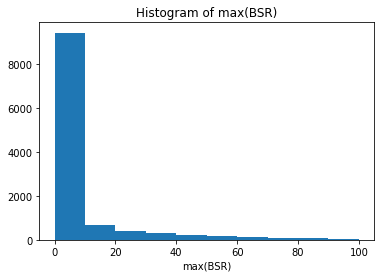

In [35]:
import matplotlib.pyplot as plt

plt.hist(bsr_max)
plt.title('Histogram of max(BSR)')
plt.xlabel('max(BSR)')

In [33]:
np.mean(bsr_max<10)

0.8185686989751607

In [9]:
# bsr 중에 <0, >100은 오류이니 이런 경우는 제외해야됨. 즉 <0, >100은 nan으로 처리
bsr_means = df_data['bsr_track'].apply(lambda x: np.nanmean(x))
bsr_means

0        0.000000
1        1.606708
2        0.006670
3        0.000000
4        0.000000
           ...   
11509    0.203529
11510    1.004296
11511    0.000000
11512    0.005472
11513    0.000000
Name: bsr_track, Length: 11514, dtype: float64

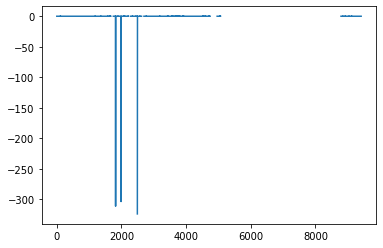

In [71]:
plt.plot(df_data.loc[718, 'bsr_track'])

In [68]:
np.mean(bsr_means<1)*100

90.01650881918498

(array([1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.800e+01, 9.059e+03,
        6.270e+02, 2.950e+02, 1.990e+02, 1.480e+02]),
 array([-1.05674158, -0.8516257 , -0.64650982, -0.44139394, -0.23627806,
        -0.03116218,  0.1739537 ,  0.37906959,  0.58418547,  0.78930135,
         0.99441723]),
 <BarContainer object of 10 artists>)

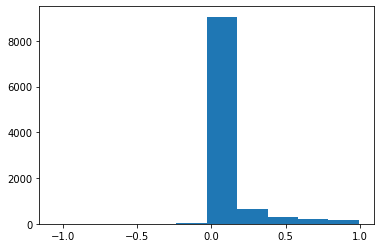

In [69]:
plt.hist(bsr_means[bsr_means<1])

In [21]:
from sklearn import metrics

# auc 계산
#df_data['bsr_track'].apply(lambda x: )

for idx, row in tqdm(df_data.iterrows(), total = df_data.shape[0]):
    bsr = np.array(row['bsr_track'], dtype=np.float32)
    #bsr = bsr[~np.isnan(bsr)]
    
    mask = np.where((bsr>=0) & (bsr<=100))[0]
    y_val = bsr[mask]
    
    df_data.loc[idx, 'bsr_auc'] = metrics.auc(mask, y_val)

100%|██████████| 11514/11514 [00:08<00:00, 1320.94it/s]


In [50]:
err_rows = df_data[['bsr_track','bsr_auc']][df_data['bsr_auc']>200000]
err_rows

,bsr_track,bsr_auc
54,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",202510.653384
266,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",216416.199751
469,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",221978.503243
664,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",215194.003828
761,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",534318.959162
...,...,...
10816,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",208845.203609
10863,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",246355.300456
11040,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",257523.400229
11258,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",292733.754578


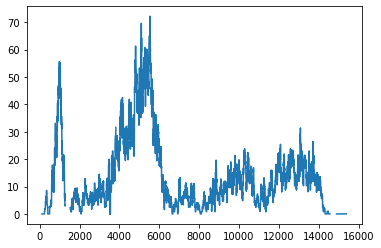

In [48]:
plt.plot(err_rows[54].values)

In [36]:
np.mean(aucs), np.mean(aucs==0)

(7393.571907569781, 0.4877540385617509)

(array([1.09e+04, 2.76e+02, 1.32e+02, 5.40e+01, 3.50e+01, 2.40e+01,
        1.30e+01, 2.20e+01, 1.50e+01, 9.00e+00]),
 array([     0.        ,  29965.51050267,  59931.02100534,  89896.53150801,
        119862.04201068, 149827.55251335, 179793.06301602, 209758.57351868,
        239724.08402135, 269689.59452402, 299655.10502669]),
 <BarContainer object of 10 artists>)

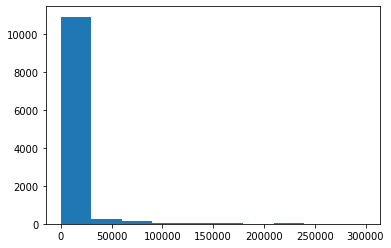

In [37]:
plt.hist(aucs[aucs<300000])

In [22]:
c = 'bsr_auc'
model = sm.Logit(df_data['POD'], df_data[['intercept', c]])
res = model.fit()
b = res.params[c]
pval = res.pvalues[c]
print('{}\tb={:.3f}, exp(b)={:.3f}, pval={:.3f}'.format(c, b, np.exp(b), pval))

Optimization terminated successfully.
         Current function value: 0.211952
         Iterations 7
bsr_auc	b=0.000, exp(b)=1.000, pval=0.000


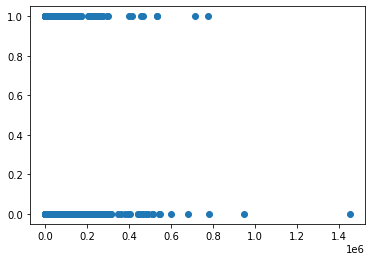

In [24]:
aucs = df_data['bsr_auc'].values
plt.scatter(aucs, df_data['POD'].values)

### np.nanmean(bsr>thres)에 대한 odds ratio

In [17]:
# np.nanmean(bsr>thres)에 대한 odds ratio
odd_ratios = []
for thres in bsr_thresholds:
    c = 'mean_upper{}'.format(thres)
    model = sm.Logit(df_data['POD'], df_data[['intercept', c]])
    res = model.fit()
    b = res.params[c]
    pval = res.pvalues[c]
    odd_ratios.append(np.exp(b))
    print('{}\tb={:.3f}, exp(b)={:.3f}, pval={:.3f}'.format(c, b, np.exp(b), pval))

Optimization terminated successfully.
         Current function value: 0.211078
         Iterations 7
mean_upper5	b=2.589, exp(b)=13.311, pval=0.000
Optimization terminated successfully.
         Current function value: 0.211839
         Iterations 7
mean_upper10	b=2.920, exp(b)=18.548, pval=0.000
Optimization terminated successfully.
         Current function value: 0.212378
         Iterations 7
mean_upper15	b=3.195, exp(b)=24.414, pval=0.000
Optimization terminated successfully.
         Current function value: 0.212794
         Iterations 7
mean_upper20	b=3.523, exp(b)=33.893, pval=0.000
Optimization terminated successfully.
         Current function value: 0.213168
         Iterations 7
mean_upper25	b=3.842, exp(b)=46.597, pval=0.000
Optimization terminated successfully.
         Current function value: 0.213507
         Iterations 7
mean_upper30	b=4.161, exp(b)=64.132, pval=0.000
Optimization terminated successfully.
         Current function value: 0.213825
         Iterations 7

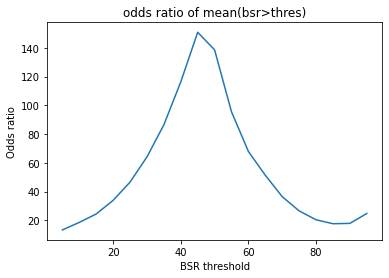

In [11]:
import matplotlib.pyplot as plt

plt.plot(bsr_thresholds, odd_ratios)
plt.title('odds ratio of mean(bsr>thres)')
plt.xlabel('BSR threshold')
plt.ylabel('Odds ratio')
plt.show()

In [81]:
# np.nanmean(bsr>thres)에 대한 odds ratio
odd_ratios = []
for thres in bsr_thresholds:
    c = 'upper{}'.format(thres)
    model = sm.Logit(df_data['POD'], df_data[['intercept', c]])
    res = model.fit()
    b = res.params[c]
    pval = res.pvalues[c]
    odd_ratios.append(np.exp(b))
    print('{}\tb={:.3f}, exp(b)={:.3f}, pval={:.3f}'.format(c, b, np.exp(b), pval))

Optimization terminated successfully.
         Current function value: 0.206564
         Iterations 7
upper0.1	b=0.055, exp(b)=1.056, pval=0.000
Optimization terminated successfully.
         Current function value: 0.206564
         Iterations 7
upper0.12000000000000001	b=0.055, exp(b)=1.056, pval=0.000
Optimization terminated successfully.
         Current function value: 0.206564
         Iterations 7
upper0.14	b=0.055, exp(b)=1.056, pval=0.000
Optimization terminated successfully.
         Current function value: 0.206564
         Iterations 7
upper0.16000000000000003	b=0.055, exp(b)=1.056, pval=0.000
Optimization terminated successfully.
         Current function value: 0.206564
         Iterations 7
upper0.18000000000000002	b=0.055, exp(b)=1.056, pval=0.000
Optimization terminated successfully.
         Current function value: 0.206564
         Iterations 7
upper0.2	b=0.055, exp(b)=1.056, pval=0.000
Optimization terminated successfully.
         Current function value: 0.206564
 

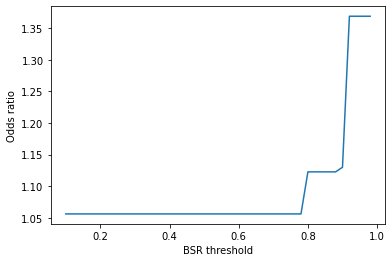

In [83]:
import matplotlib.pyplot as plt

plt.plot(bsr_thresholds, odd_ratios)
plt.xlabel('BSR threshold')
plt.ylabel('Odds ratio')
plt.show()

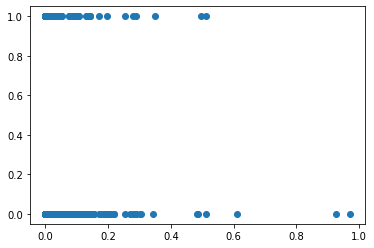

In [16]:
plt.scatter(df_data['mean_upper40'].values, df_data['POD'].values)

In [18]:
np.mean(df_data['sum_upper10'].values)

197.2346708355046

In [15]:
df_data

,fileid,bis,anes,anes_type,a_num,ane_track,bis_track,bsr,bsr_track,POD,...,mean_upper75,sum_upper80,mean_upper80,sum_upper85,mean_upper85,sum_upper90,mean_upper90,sum_upper95,mean_upper95,intercept
0,R10_200311_134656.vital,True,[Datex-Ohmeda/ET_AGENT1],SEVO,1,"[2.0, nan, 2.5999999046325684, nan, 2.79999995...","[49.70000076293945, 48.900001525878906, 49.299...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,A5_190718_075007.vital,True,[Primus/EXP_SEVO],SEVO,1,"[2.0999999046325684, nan, nan, nan, nan, nan, ...","[73.0999984741211, 74.4000015258789, 72.800003...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,R9_200706_074752.vital,True,[Primus/EXP_SEVO],SEVO,1,"[0.800000011920929, nan, nan, nan, nan, nan, n...","[72.0999984741211, 72.4000015258789, 73.5, 74....",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,D4_200717_100153.vital,True,[Datex-Ohmeda/ET_AGENT1],SEVO,1,"[1.899999976158142, nan, 1.2000000476837158, 1...","[nan, 45.29999923706055, 45.400001525878906, 4...",[BIS/SR],"[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,E5_200205_133523.vital,True,[Primus/EXP_SEVO],SEVO,1,"[1.2000000476837158, nan, nan, nan, nan, nan, ...","[44.70000076293945, 44.70000076293945, 45.2000...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11509,A2_191017_101910.vital,True,[Orchestra/PPF20_CE],PPF,1,"[0.2150000035762787, 0.367000013589859, 0.4070...","[97.4000015258789, 97.4000015258789, 97.400001...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11510,A5_190104_074655.vital,True,[Primus/EXP_SEVO],SEVO,1,"[0.20000000298023224, nan, nan, nan, nan, nan,...","[nan, nan, nan, nan, nan, 85.0999984741211, 85...",[BIS/SR],"[nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11511,A4_190411_085050.vital,True,[Datex-Ohmeda/ET_AGENT1],SEVO,1,"[1.600000023841858, nan, 1.2999999523162842, n...","[82.69999694824219, 77.0, 64.80000305175781, 5...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11512,A2_191211_113926.vital,True,[Orchestra/PPF20_CE],PPF,1,"[0.2460000067949295, 0.3179999887943268, 0.453...","[97.70000457763672, 97.70000457763672, 97.7000...",[BIS/SR],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### np.nansum(bsr>thres)에 대한 odds ratio

In [29]:
# np.nanmean(bsr>thres)에 대한 odds ratio
odd_ratios = []
for thres in bsr_thresholds:
    c = 'sum_upper{}'.format(thres)
    model = sm.Logit(df_data['POD'], df_data[['intercept', c]])
    res = model.fit()
    b = res.params[c]
    pval = res.pvalues[c]
    odd_ratios.append(np.exp(b))
    print('{}\tb={:.3f}, exp(b)={:.3f}, pval={:.3f}'.format(c, b, np.exp(b), pval))

Optimization terminated successfully.
         Current function value: 0.211068
         Iterations 7
sum_upper5	b=0.000, exp(b)=1.000, pval=0.000
Optimization terminated successfully.
         Current function value: 0.211921
         Iterations 7
sum_upper10	b=0.000, exp(b)=1.000, pval=0.000
Optimization terminated successfully.
         Current function value: 0.212429
         Iterations 7
sum_upper15	b=0.000, exp(b)=1.000, pval=0.000
Optimization terminated successfully.
         Current function value: 0.212848
         Iterations 7
sum_upper20	b=0.000, exp(b)=1.000, pval=0.000
Optimization terminated successfully.
         Current function value: 0.213178
         Iterations 7
sum_upper25	b=0.000, exp(b)=1.000, pval=0.000
Optimization terminated successfully.
         Current function value: 0.213484
         Iterations 7
sum_upper30	b=0.000, exp(b)=1.000, pval=0.000
Optimization terminated successfully.
         Current function value: 0.213764
         Iterations 7
sum_upper35

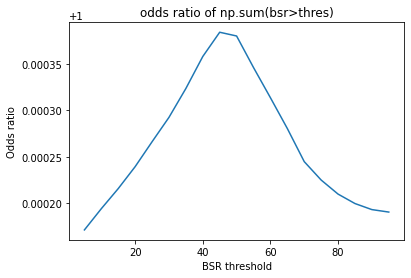

In [30]:
import matplotlib.pyplot as plt

plt.plot(bsr_thresholds, odd_ratios)
plt.title('odds ratio of np.sum(bsr>thres)')
plt.xlabel('BSR threshold')
plt.ylabel('Odds ratio')
plt.show()